# **PART = 1**

# Lets import all the necessary libraries

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Embedding, Flatten, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Lets mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Lets load the dataset**

In [ ]:
from keras.datasets import imdb

vocab_size = 10000 

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size) 

17473536/17464789 [==============================] - 0s 0us/step


# **Lets define the vocab size and number of word used from each review**

In [ ]:
from keras.preprocessing.sequence import pad_sequences
vocab_size = 10000 
maxlen = 300  

# Lets load dataset as a list and make all sequences of the same length

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test =  pad_sequences(x_test, maxlen=maxlen)

# Checking the shape of train and test dataset

In [ ]:
print(x_train.shape)
print(x_test.shape)

(25000, 300)
(25000, 300)


In [ ]:
len(x_train[0])

300

# Lets get the words and create a dictionary with index as key and the word as value

In [ ]:
words=imdb.get_word_index()
print(words['the'])

index=dict([(v,k) for (k,v) in words.items() if v<=10000])
index[1]

1654784/1641221 [==============================] - 0s 0us/step
1


'the'

In [ ]:
len(index)

10000

# **Lets load the whole embedding into memory**

In [ ]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/AIML Program/Project/NLP2/DataSet - glove.6B.50d.txt')

for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


# Lets Map the embedding vector with the words in the index:word dictionary defined before and store in embedding_matrix

In [ ]:

embedding_matrix = np.zeros((vocab_size+1, 50))

for i,word in index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(10001, 50)


# **Now lets build the model**

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed,Bidirectional
from tensorflow.keras.layers import Embedding
import tensorflow as tf
from sklearn.metrics import confusion_matrix

input_layer=Input(shape=(maxlen,),dtype=tensorflow.int64)
embedding = Embedding(vocab_size+1,50,weights=[embedding_matrix],trainable=True, input_length=maxlen)(input_layer)

# Here we are defining the bidirectional LSTM model

In [ ]:
lstm = Bidirectional(LSTM(20))(embedding)
out = (Dense(2, activation="softmax"))(lstm)

In [ ]:
from tensorflow.keras import backend as K
def custom_sparse_categorical_accuracy(y_true, y_pred):
    return K.cast(K.equal(K.max(y_true, axis=-1),
                          K.cast(K.argmax(y_pred, axis=-1), K.floatx())),
                  K.floatx())

# Compile the model

In [ ]:
model = Model(input_layer, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=[custom_sparse_categorical_accuracy])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 50)           500050    
                                                                 
 bidirectional (Bidirectiona  (None, 40)               11360     
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 82        
                                                                 
Total params: 511,492
Trainable params: 511,492
Non-trainable params: 0
_________________________________________________________________


# **Lets fit the model**

In [ ]:
x_train=x_train[:10000,:]
y_train=y_train[:10000]

model.fit(np.array(x_train),np.array(y_train),batch_size=20, epochs=5, verbose=1)

Epoch 1/5
500/500 [==============================] - 70s 133ms/step - loss: 0.6575 - custom_sparse_categorical_accuracy: 0.5897
Epoch 2/5
500/500 [==============================] - 66s 131ms/step - loss: 0.4371 - custom_sparse_categorical_accuracy: 0.7990
Epoch 3/5
500/500 [==============================] - 69s 138ms/step - loss: 0.2627 - custom_sparse_categorical_accuracy: 0.8968
Epoch 4/5
500/500 [==============================] - 66s 133ms/step - loss: 0.1655 - custom_sparse_categorical_accuracy: 0.9443
Epoch 5/5
500/500 [==============================] - 69s 137ms/step - loss: 0.0971 - custom_sparse_categorical_accuracy: 0.9719


# **As we can see here that custom_sparse_categorical_accuracy: 0.9719 and loss: 0.0971. Which means our model is working pretty fine**

In [ ]:
x_test=x_test[:5000,:]
y_test=y_test[:5000]

test_pred = model.predict(np.array(x_test), verbose=1)

157/157 [==============================] - 7s 36ms/step


# **Mapping the greater value as 1 and the lesser probability as 0**

In [ ]:
test_pred = [1 if j>i else 0 for i,j in test_pred]

test_pred[1]

1

# **Lets create the confusion matrix**

In [ ]:
confusion_matrix(y_test, test_pred)

array([[2140,  431],
       [ 353, 2076]])

# **As we can see here that True positive value is 2076 and True negative value is 2140. That means our model is performing its task very well**

# Lets Retrive the output of each layer in keras for a given single test sample from the trained model we built

In [ ]:
model.layers[2].output

<KerasTensor: shape=(None, 40) dtype=float32 (created by layer 'bidirectional')>

In [ ]:
layer_outputs=[out.output for out in model.layers][1:]
model_input = model.input

In [ ]:
functions = [K.function([model_input],[out]) for out in layer_outputs]

outs = [func([x_test]) for func in functions]

print(outs[1])    # Output of Bidirectional layer

print(outs[2])    # Output of Dense softmax layer

print(outs[0])    # Output of the embedding layer

[array([[ 0.05037985,  0.08863832, -0.48881733, ..., -0.05949384,
        -0.01918741, -0.01674705],
       [-0.5417663 ,  0.589969  ,  0.8805925 , ..., -0.05957677,
        -0.01892886, -0.01690206],
       [-0.38703278,  0.38663995,  0.5308061 , ...,  0.5786498 ,
         0.53038794, -0.08311957],
       ...,
       [ 0.02964257,  0.33380565,  0.6859438 , ..., -0.05949384,
        -0.01918742, -0.01674705],
       [ 0.06757696,  0.36389595,  0.44367447, ..., -0.05949387,
        -0.01918742, -0.01674705],
       [-0.21156886,  0.4688213 ,  0.8271618 , ..., -0.05949386,
        -0.01918742, -0.01674705]], dtype=float32)]
[array([[0.9078768 , 0.09212326],
       [0.00168339, 0.99831665],
       [0.01863885, 0.9813611 ],
       ...,
       [0.00333564, 0.99666435],
       [0.05370776, 0.9462922 ],
       [0.00605898, 0.99394107]], dtype=float32)]
[array([[[-8.3878497e-03, -3.3890702e-02,  8.2194924e-02, ...,
          2.3254897e-02,  8.2241168e-06,  5.1855545e-02],
        [-8.3878497e-

# **PART = 2**

# **Lets load the data and read the json**

In [ ]:
import json
data = [json.loads(line) for 
        line in open('/content/drive/MyDrive/AIML Program/Project/NLP2/Sarcasm_Headlines_Dataset_v2.json', 'r')]

## **Lets Convert the dictionary to a dataframe**

In [ ]:
new_df = pd.DataFrame.from_dict(data) 

# **Lets check the dataset**

In [ ]:
new_df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# Lets drop article_link from dataset

In [ ]:
new_df2 = new_df.drop(['article_link'],axis=1)

# Again check the dataset

In [ ]:
new_df2.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


# **Lets get the length of each headline and add a column for that**

In [ ]:
new_df2["headline_len"] = new_df2["headline"].str.len()

In [ ]:
new_df2.head()

,is_sarcastic,headline,headline_len
0,1,thirtysomething scientists unveil doomsday clo...,61
1,0,dem rep. totally nails why congress is falling...,79
2,0,eat your veggies: 9 deliciously different recipes,49
3,1,inclement weather prevents liar from getting t...,52
4,1,mother comes pretty close to using word 'strea...,61


# **Lets initialize parameter values-**

# Set values for max_features, maxlen, & embedding_size.

# max_features: Number of words to take from tokenizer(most frequent words)

# maxlen: Maximum length of each sentence to be limited to 25

# embedding_size: size of embedding vector i.e. 50

In [ ]:
max_features = 10000
maxlen = 25
embedding_size = 50

# Lets apply tensorflow.keras Tokenizer and get indices for words.Initialize Tokenizer object with number of words as 10000.Fit the tokenizer object on headline column.Convert the text to sequence

In [ ]:
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(new_df2['headline'])

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# **Lets Create the tokenized vectors**

In [ ]:
train_seqs = tokenizer.texts_to_sequences(new_df2['headline'])

# Pading each example with a maximum length and Converting target column into numpy array

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=maxlen)

In [ ]:
Y = new_df2["is_sarcastic"].values

# lets check the type

In [ ]:
print(type(Y))

<class 'numpy.ndarray'>


# **Lets plot to see the sarcastic status**

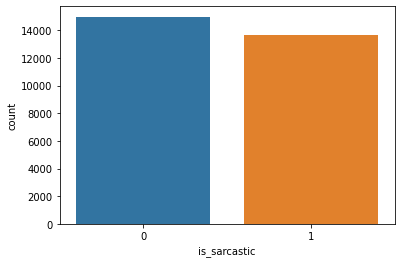

In [ ]:
sns.countplot(x='is_sarcastic',data=new_df2);

# **As we can see here that data is fairly balanced in terms of sarcastic and non sarcastic tagging so no oversampling or undersampling required Vocab mapping.Also there is no word for 0th index**

In [ ]:
tokenizer.word_index

{'<unk>': 1,
 'to': 2,
 'of': 3,
 'the': 4,
 'in': 5,
 'for': 6,
 'a': 7,
 'on': 8,
 'and': 9,
 'with': 10,
 'is': 11,
 'new': 12,
 'trump': 13,
 'man': 14,
 'at': 15,
 'from': 16,
 'about': 17,
 'by': 18,
 'after': 19,
 'you': 20,
 'this': 21,
 'out': 22,
 'up': 23,
 'be': 24,
 'as': 25,
 'that': 26,
 'it': 27,
 'how': 28,
 'not': 29,
 'he': 30,
 'his': 31,
 'are': 32,
 'your': 33,
 'just': 34,
 'what': 35,
 'all': 36,
 'who': 37,
 'has': 38,
 'will': 39,
 'report': 40,
 'into': 41,
 'more': 42,
 'one': 43,
 'have': 44,
 'year': 45,
 'over': 46,
 'why': 47,
 'day': 48,
 'u': 49,
 'area': 50,
 'woman': 51,
 'can': 52,
 's': 53,
 'says': 54,
 'donald': 55,
 'time': 56,
 'first': 57,
 'like': 58,
 'no': 59,
 'her': 60,
 'get': 61,
 'off': 62,
 'old': 63,
 "trump's": 64,
 'life': 65,
 'now': 66,
 'people': 67,
 "'": 68,
 'an': 69,
 'house': 70,
 'still': 71,
 'obama': 72,
 'white': 73,
 'back': 74,
 'make': 75,
 'was': 76,
 'than': 77,
 'women': 78,
 'if': 79,
 'down': 80,
 'when': 81,
 '

# Lets set number of words, since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [ ]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

30888


# Lets Create embedding matrix

In [ ]:
EMBEDDING_FILE = '/content/drive/MyDrive/AIML Program/Project/NLP2/DataSet - glove.6B.50d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]    
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')    
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 50))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

# **Now its time to define the model**

We are using Sequential model instance and then adding Embedding layer, Bidirectional(LSTM) layer, flatten it, then dense and dropout layers as required. In the end add a final dense layer with sigmoid activation for binary classification.
We have not trained the embeddings generated from glove data as we are getting good results without it as well

In [ ]:
lstm_out = 196
model = Sequential()
model.add(Embedding(num_words,
                    embedding_size,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=False))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# **Lets Compile the model and summarise the model**

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 50)            1544400   
                                                                 
 spatial_dropout1d (SpatialD  (None, 25, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 392)              387296    
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 393       
                                                                 
Total params: 1,932,089
Trainable params: 387,689
Non-tr

# Lets split the model

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(22895, 25) (22895,)
(5724, 25) (5724,)


# Fit the model

In [ ]:
batch_size = 64
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, 
                    verbose = 1, validation_split=0.1)

Epoch 1/10
322/322 [==============================] - 108s 319ms/step - loss: 0.6182 - accuracy: 0.6556 - val_loss: 0.5392 - val_accuracy: 0.7441
Epoch 2/10
322/322 [==============================] - 111s 344ms/step - loss: 0.5570 - accuracy: 0.7138 - val_loss: 0.4768 - val_accuracy: 0.7878
Epoch 3/10
322/322 [==============================] - 110s 341ms/step - loss: 0.5192 - accuracy: 0.7388 - val_loss: 0.4266 - val_accuracy: 0.8013
Epoch 4/10
322/322 [==============================] - 101s 315ms/step - loss: 0.4928 - accuracy: 0.7567 - val_loss: 0.4167 - val_accuracy: 0.8052
Epoch 5/10
322/322 [==============================] - 109s 337ms/step - loss: 0.4658 - accuracy: 0.7732 - val_loss: 0.4192 - val_accuracy: 0.8009
Epoch 6/10
322/322 [==============================] - 112s 348ms/step - loss: 0.4536 - accuracy: 0.7811 - val_loss: 0.3801 - val_accuracy: 0.8288
Epoch 7/10
322/322 [==============================] - 113s 351ms/step - loss: 0.4337 - accuracy: 0.7936 - val_loss: 0.4013 -

# **As we can see here that accuracy is about 81% and loss is 0.40. which is very good for our model**

# Now lets Plot the model accuracy and loss across epochs

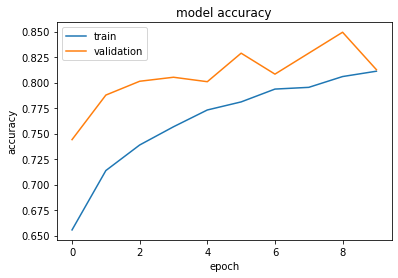

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

# Now lets summarize history for loss

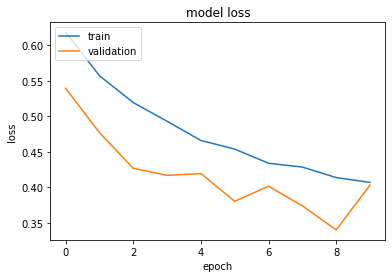

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

# **Lets evaluate our model**

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)

179/179 [==============================] - 6s 31ms/step - loss: 0.3919 - accuracy: 0.8218


#Now lets predict the class of dataset with thw help of this model

In [ ]:
pred = (model.predict(X_test) > 0.5).astype("int32")
pred[:5]

array([[1],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

# **Lets create the classification report for this model**

In [ ]:
print(classification_report(Y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.91      0.73      0.81      2995
    Sarcastic       0.76      0.92      0.83      2729

     accuracy                           0.82      5724
    macro avg       0.83      0.83      0.82      5724
 weighted avg       0.84      0.82      0.82      5724



# **Now lets create the confusion matrix**

In [ ]:
cm = confusion_matrix(Y_test,pred)
cm

array([[2194,  801],
       [ 219, 2510]])

# Lets plot this matrix

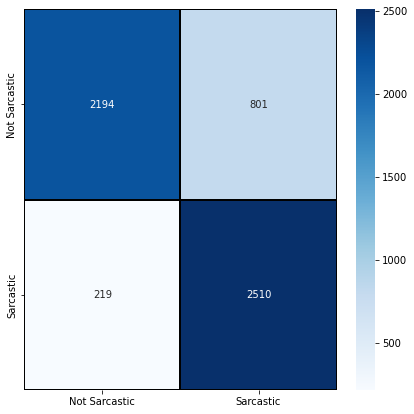

In [ ]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

# **As we can see here that True postive value is 2510 and True negative value is 2194. So here our model does a fairly decent job of predicting sarcastic comments with test accuracy of ~82%**